In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
physical_device = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_device[0],True)

In [3]:
# Constants
BATCH_SIZE = 64
IMAGE_SIZE = 120
Channel = 1
Epochs = 5
n_class = 4

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 1)

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/COVID-19_Radiography_Dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale')
class_names = dataset.class_names

Found 21165 files belonging to 4 classes.


In [5]:
# 92% for train set, 4%(~1000 images) for Dev set, and 4% for test set 

def get_dataset_partition(dataset,train_split=0.92,dev_split=0.04,test_split = 0.04,shuffle=True, shuffle_size=10000):
    assert (train_split + dev_split + test_split) == 1
    data_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * data_size)
    dev_size = int(dev_split * data_size)

    train_data = dataset.take(train_size)
    dev_data = dataset.skip(train_size).take(dev_size)
    test_data = dataset.skip(train_size).skip(dev_size)

    return train_data, dev_data, test_data

In [13]:
def CNN_Model(train_data,dev_data,test_data,learning_rate):
    
    resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
    ])
    augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
    ])
    
    # Dropout at the input layer is not required.

    # As the filter increase we would try to increase the dropout rate.
    model = models.Sequential([
        resize_rescale, augmentation,
        layers.Conv2D(32,kernel_size=(3, 3),activation='relu',input_shape=input_shape,padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),
        layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        layers.Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.L2(l2=0.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(64, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(n_class, activation='softmax')
    ])
    model.build(input_shape=input_shape)

    model.summary()
    inital_learning_rate = learning_rate

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=inital_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'])

    log_dir = "logs/fit/Logs_" + str(inital_learning_rate)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(train_data,batch_size=BATCH_SIZE,validation_data=dev_data,verbose=1,epochs=Epochs,callbacks=[tensorboard_callback])

    test_eval = model.evaluate(test_data)

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    

    return acc,val_acc,loss,val_loss,test_eval

In [7]:
train_data, dev_data, test_data = get_dataset_partition(dataset,train_split=0.92,dev_split=0.04,test_split=0.04,shuffle=True)

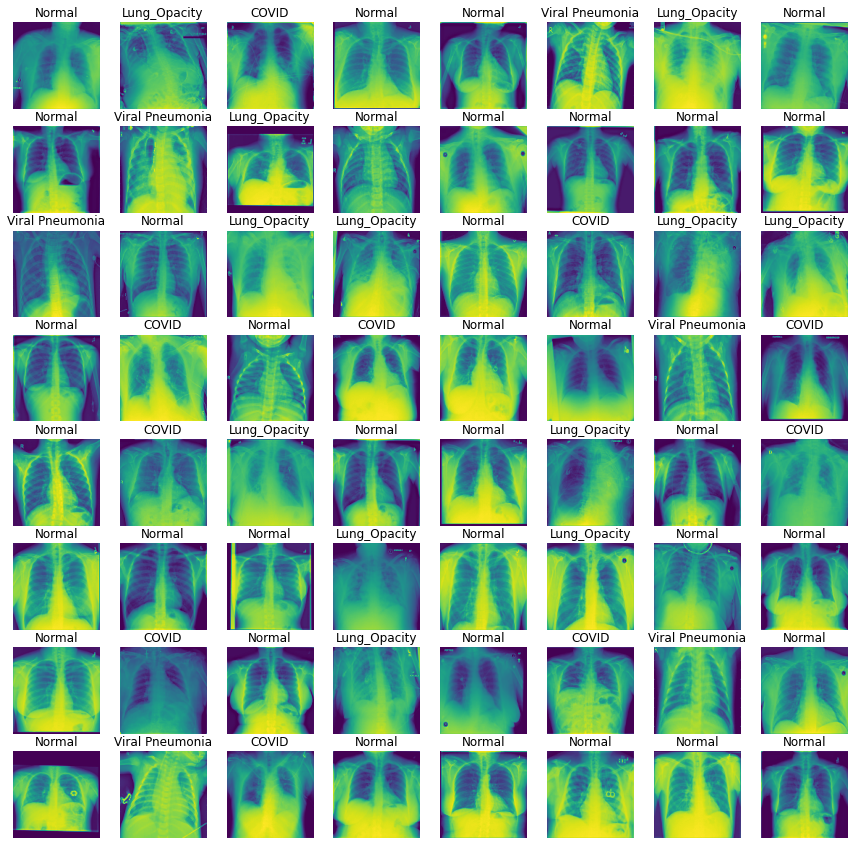

In [19]:
freq = []
plt.figure(figsize=(15,15))
for image_batch,labels_batch in test_data:
    freq.append(class_names[labels_batch[i].numpy()])
    for i in range(64):
        ax = plt.subplot(8,8,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i].numpy()])
        plt.axis("off")


In [8]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
dev_data = dev_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
acc,val_acc,loss,val_loss,test_eval = CNN_Model(train_data = train_data, dev_data = dev_data, test_data = test_data,learning_rate = 0.01)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (64, 120, 120, 1)         0         
_________________________________________________________________
sequential_1 (Sequential)    (64, 120, 120, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (64, 120, 120, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (64, 120, 120, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (64, 60, 60, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (64, 60, 60, 64)          18496     
_________________________________________________________________
batch_normalization_1 (Batch (64, 60, 60, 64)         

In [12]:
test_eval[1]

0.546875

In [14]:
# Checking for 10 random learning rate
data = []
for i in range(10):
    r = -4*np.random.rand()
    learning_rate = 10**r
    acc,val_acc,loss,val_loss,test_eval = CNN_Model(train_data = train_data, dev_data = dev_data, test_data = test_data,learning_rate = learning_rate)
    candidate = {
        'TrainAccuracy':acc,
        'DevAccuracy':val_acc,
        'TrainLoss':loss,
        'DevLoss':val_loss,
        'TestAccuracy':test_eval[1],
        'TestLoss':test_eval[0],
        'Learning_Rate':learning_rate
    }
    data.append(candidate)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (64, 120, 120, 1)         0         
_________________________________________________________________
sequential_4 (Sequential)    (64, 120, 120, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (64, 120, 120, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (64, 120, 120, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (64, 60, 60, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (64, 60, 60, 64)          18496     
_________________________________________________________________
batch_normalization_7 (Batch (64, 60, 60, 64)         

In [16]:
import pandas as pd
df_data = pd.DataFrame(data)
df_data.to_csv('Learning_rate_performance.csv',index=False)

In [18]:
dataframe = pd.read_csv('Learning_rate_performance.csv')
dataframe.head()

,TrainAccuracy,DevAccuracy,TrainLoss,DevLoss,TestAccuracy,TestLoss,Learning_Rate
0,"[0.4776971638202667, 0.4826362133026123, 0.482...","[0.49879807233810425, 0.49879807233810425, 0.4...","[41.431915283203125, 1.2012356519699097, 1.189...","[1.253308653831482, 1.1997137069702148, 1.2000...",0.476562,1.187920,0.045704
1,"[0.4769769012928009, 0.48109275102615356, 0.48...","[0.49879807233810425, 0.49879807233810425, 0.4...","[840.450927734375, 3.943730115890503, 1.635417...","[8.170186042785645, 2.0928499698638916, 1.3928...",0.476562,1.218089,0.256388
2,"[0.6177908182144165, 0.7010855674743652, 0.746...","[0.26201921701431274, 0.2992788553237915, 0.47...","[6.571429252624512, 3.514791488647461, 2.01750...","[6.33234977722168, 4.538537502288818, 2.319293...",0.581473,1.543992,0.000164
3,"[0.5952564477920532, 0.6355919241905212, 0.643...","[0.26201921701431274, 0.4891826808452606, 0.52...","[5.0265092849731445, 2.706629514694214, 2.1566...","[3.477872133255005, 3.016022205352783, 2.10231...",0.683036,2.180100,0.007721
4,"[0.47841745615005493, 0.4826362133026123, 0.48...","[0.49879807233810425, 0.49879807233810425, 0.4...","[155.4214324951172, 1.4604631662368774, 1.2455...","[1.9368412494659424, 1.3014514446258545, 1.231...",0.476562,1.190017,0.104779


<AxesSubplot:xlabel='Learning_Rate', ylabel='TestAccuracy'>

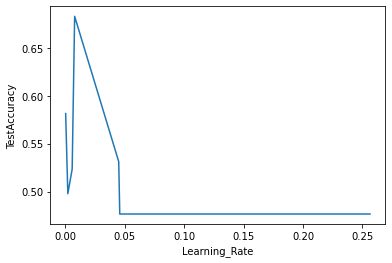

In [20]:
import seaborn as sns

dataframe.sort_values(['Learning_Rate'])

sns.lineplot(x='Learning_Rate',y='TestAccuracy',data=dataframe)

In [26]:
col = dataframe['TestAccuracy']
max = col.max()
df = dataframe.loc[dataframe['TestAccuracy']==max]
df

,TrainAccuracy,DevAccuracy,TrainLoss,DevLoss,TestAccuracy,TestLoss,Learning_Rate
3,"[0.5952564477920532, 0.6355919241905212, 0.643...","[0.26201921701431274, 0.4891826808452606, 0.52...","[5.0265092849731445, 2.706629514694214, 2.1566...","[3.477872133255005, 3.016022205352783, 2.10231...",0.683036,2.1801,0.007721


In [43]:
list_trainacc = df['TrainAccuracy']
list_devacc = df['DevAccuracy']
list_trainloss = df['TrainLoss']
list_devloss = df['DevLoss']
list_trainacc.iloc[-1]
print("Training Accuracy :- ",list_trainacc.iloc[-1],"\n","Dev Accuracy :- ",list_devacc.iloc[-1],"\n","Training Loss :- ",list_trainloss.iloc[-1],"\n","Dev Loss :- ",list_devloss.iloc[-1])

Training Accuracy :-  [0.5952564477920532, 0.6355919241905212, 0.6438750624656677, 0.6537531614303589, 0.6607500910758972] 
 Dev Accuracy :-  [0.26201921701431274, 0.4891826808452606, 0.5240384340286255, 0.6850961446762085, 0.6694711446762085] 
 Training Loss :-  [5.0265092849731445, 2.706629514694214, 2.156656265258789, 2.090498924255371, 2.1226370334625244] 
 Dev Loss :-  [3.477872133255005, 3.016022205352783, 2.1023125648498535, 1.7337826490402222, 2.1652987003326416]


### _Therefore from this small experiment Learning Rate 0.007721 is giving us the best results._

- And as a result of it Training Accuracy, Dev Accuracy and Test Accuracy are pretty close to each other.